# **Rossmann Sales Trends & Forecasting: A Data-Driven Approach**

**Group: MY-G2-Sales**  
**Team Members**:   
Keshav Thinakaran - 36034789  
Elaine Tjandra - 35008709  
Jingyuan Yao - 35595272  
Yin Haotian - 35427140  

### **Executive Summary**
This project investigates how historical sales data from over 1,000 Rossmann stores between 2013 and 2015 can be leveraged to improve sales forecasting and store management. The analysis aimed to identify key drivers of store performance, explore temporal patterns, and develop predictive models to enhance forecasting accuracy.

Tier-based exploratory analysis  revealed clear performance differences across the Rossmann store network. The top 20% of stores generated the majority of total revenue and displayed smoother, more consistent growth trends, while middle- and bottom-tier stores showed greater variability and irregular sales behaviour. A baseline Seasonal Naïve (Lag-4) evaluation indicated that top-tier stores had the lowest forecast error (MAPE ≈ 2.6%), whereas bottom-tier stores exhibited the highest (≈ 4.4%), demonstrating that sales stability decreases progressively across store tiers.

Results indicate that promotional activities constitute the most influential factor affecting sales, with revenue during promotion periods increasing by up to nearly 100% compared to non-promotion days. However, the effect of promotions varies across stores and periods, suggesting that timing and intensity are not always optimal. Historical sales trends, captured through lag and moving average features, were found to substantially improve forecast performance, highlighting the predictive value of recent sales momentum.

Analysis of weekday and holiday patterns revealed consistent fluctuations, with Mondays typically experiencing the highest sales and Sundays and holidays demonstrating lower performance. These patterns provide a basis for optimizing staffing and inventory allocation. Predictive modeling, particularly using Random Forest, identified the top contributing factors to sales variation, while error analysis showed increased forecast uncertainty during overlapping promotion and holiday periods, indicating the need for adaptive planning under high-demand conditions.


Overall, the study provides actionable insights that can inform more effective promotional scheduling, targeted inventory management, and the integration of recent sales trends into forecasting models. Implementing these strategies is expected to enhance operational efficiency, improve forecast reliability, and support data-driven decision-making across the Rossmann store network.

### **Background Information**  
Rossmann is a leading retail chain in Europe with over thousands of stores, primarily selling cosmetics, household products, health items, and food. Each store’s sales are influenced by a variety of factors, including promotions, holidays, store characteristics, and customer purchasing patterns. Managing sales performance across such a large network is challenging — inaccurate forecasts can lead to overstocking, understaffing, or missed sales opportunities, directly affecting revenue and operational efficiency.

**Supplied data**  
The Rossmann sales dataset contains historical data from approximately 1,115 stores covering the period from 2013 to July 2015. The dataset includes key information such as store ID, date, number of customers, promotions, holidays, and other operational features. This rich dataset provides an opportunity to explore sales trends, seasonal effects, promotional impacts, and other patterns across different stores and time periods.

## **Main Research Question:**
## How can Rossmann use historical sales data to improve sales forecasting and make data-driven operational decisions?

#### **Purpose of the Project**
The main objective of this project is to analyze historical sales data from over 1,000 Rossmann stores (2013–2015) to uncover patterns and identify the key drivers of store sales. Understanding these factors will allow the company to better plan inventory, staffing, and promotional activities, ultimately improving profitability and customer satisfaction.

#### **Focus of Analysis**
1. Top-performing stores – identifying the characteristics and strategies associated with consistently high sales.

2. Feature analysis – investigating how variables such as promotions, holidays, store type, and historical sales trends influence performance.

3. Predictive modelling – using Linear Regression and Random Forest to forecast future sales and assess which factors most strongly affect predictions.

4. Error analysis – examining when and why forecasting errors become larger, particularly during high-demand periods such as holidays or major promotions.

This study aim to provide Rossmann with actionable insights into what drives store performance and how to improve forecast reliability. These findings can support more informed business decisions — from optimizing promotional timing and resource allocation to enhancing long-term sales strategies — enabling the company to strengthen its competitive position in the retail market.



#### **Import Statements**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import math
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.api.types import PeriodDtype

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

## **1. Data pre-processing and manipulation**

### **Data Overview**

In [7]:
# Load the Data
df = pd.read_csv('Rossmann_train.csv', low_memory=False)

**Information of the dataset**  
- The sales forecasting dataset has **1017209 observations** with **9 variables**.  
- There are 1115 different stores in the observation.  
- Based on the information given in `df.info()`, the data type of 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', and 'SchoolHoliday' are **integer**; 'Date' and 'StateHoliday' are **object**.
- Based on `df.isna().sum()`, there is not any null data found in the dataset.

### **Data Cleaning & Preprocessing**

In [9]:
# 1) Date format conversion
df['Date'] = pd.to_datetime(df['Date'])

# 2) Selecte Open day
df = df[(df['Open'] == 1) & (df['Sales'] > 0)]

# 3) Missing value handling & data type transfer
df['Promo'] = df['Promo'].fillna(0).astype(int)
df['SchoolHoliday'] = df['SchoolHoliday'].fillna(0).astype(int)
df['StateHoliday'] = df['StateHoliday'].fillna('0').astype(str)
df['Store'] = df['Store'].astype(int)
df = df.dropna(subset=['Date', 'Sales', 'Store'])

# 4) Get 'Year', 'Month', and 'Day'
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Copy for modelling
df_copy = df.copy()

- The dataset is first loaded using pandas, with `low_memory=False` to ensure consistent type inference across all columns. The `Date` column is then converted to a proper datetime format, enabling time-based operations like filtering, grouping by quarter, or trend analysis.

- Next, the dataset is filtered to remove all rows where stores were closed (`Open = 0`) or had zero sales. These rows are not useful for sales performance analysis and would skew the overall trends.

- Missing values in the `Promo` and `SchoolHoliday` columns are filled with `0`, assuming that no promotion or holiday occurred when the data is missing. These columns are then cast to integer types to maintain consistency and ensure compatibility during calculations and visualizations.

- For the `StateHoliday` column, missing values are filled with `'0'`, indicating no holiday. The column is also converted to string type, as it contains categorical indicators like `'a'`, `'b'`, or `'c'`.

- Finally, the `Store` column is explicitly cast to integer type to ensure that store IDs are treated as discrete values and to prevent issues during grouping or aggregation.

## **2. Exploratory Data Analysis(EDA)**  

#### **Correlation of `Sales` & `Customers`**

In [4]:
correlation = df['Customers'].corr(df['Sales'])
print("The correlation coefficient is：", correlation)

The correlation coefficient is： 0.8235517202000218


Since the number of customers is highly correlated with sales (r = 0.8235), including it in the model would artificially inflate predictive accuracy, as customer count is not known for future periods. Therefore, it was excluded from the final model to ensure a realistic forecasting scenario and to evaluate the influence of other features such as promotions, holidays, and temporal patterns.

## **Sub-Research Questions**

## **Question 1: How do sales trends and variability differ across store tiers (top, middle, bottom), and which tier provides the most reliable foundation for accurate sales forecasting?**

**Name:** Keshav Thinakaran <br>

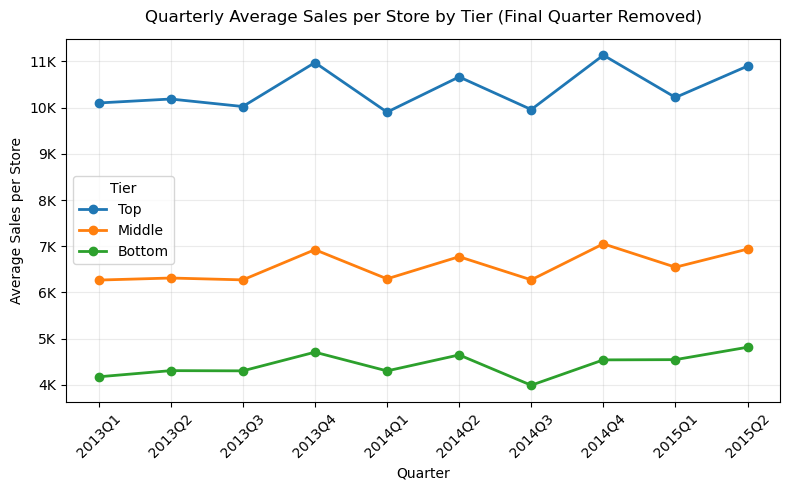

In [11]:
# Robust y-axis formatter (auto units)
def make_unit_formatter(series):
    s = pd.Series(series).dropna()
    maxv = float(s.abs().max()) if not s.empty else 0.0
    if maxv >= 1e9:
        return FuncFormatter(lambda x, pos: f'{x/1e9:.1f}B')
    if maxv >= 1e6:
        return FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M')
    if maxv >= 1e3:
        return FuncFormatter(lambda x, pos: f'{x/1e3:.0f}K')
    return FuncFormatter(lambda x, pos: f'{x:,.0f}')

# Define store tiers by total sales
store_totals = (
    df.groupby('Store', as_index=False)['Sales']
      .sum()
      .sort_values('Sales', ascending=False)
      .reset_index(drop=True)
)

n_stores = len(store_totals)
top_n     = max(1, math.ceil(0.20 * n_stores))
bottom_n  = max(1, math.ceil(0.20 * n_stores))
middle_n  = max(0, n_stores - top_n - bottom_n)

top_ids     = set(store_totals.iloc[:top_n]['Store'])
middle_ids  = set(store_totals.iloc[top_n:top_n+middle_n]['Store'])
bottom_ids  = set(store_totals.iloc[top_n+middle_n:]['Store'])

def tag_tier(store_id):
    if store_id in top_ids: return "Top"
    if store_id in middle_ids: return "Middle"
    return "Bottom"

df['Tier'] = df['Store'].map(tag_tier)

# Aggregate to QUARTER (average sales per store)
df['Quarter'] = df['Date'].dt.to_period('Q')

# Step 1: Average daily sales per store per quarter
per_store_q = (
    df.groupby(['Tier','Store','Quarter'], as_index=False)['Sales']
      .mean()
)

# Step 2: Average across stores within each tier
tier_q = (
    per_store_q.groupby(['Tier','Quarter'], as_index=False)['Sales']
               .mean()
               .sort_values(['Quarter','Tier'])
)

# Drop final incomplete quarter
last_q = tier_q['Quarter'].max()
tier_q = tier_q[tier_q['Quarter'] < last_q]

# Plot quarterly average sales per store
plt.figure(figsize=(8,5))
for tier in ['Top','Middle','Bottom']:
    if tier in tier_q['Tier'].unique():
        s = tier_q[tier_q['Tier'] == tier].set_index('Quarter')['Sales'].sort_index()
        plt.plot(s.index.astype(str), s.values, marker='o', linewidth=2, label=tier)

plt.title("Quarterly Average Sales per Store by Tier (Final Quarter Removed)", pad=12)
plt.xlabel("Quarter")
plt.ylabel("Average Sales per Store")
plt.gca().yaxis.set_major_formatter(make_unit_formatter(tier_q['Sales']))
plt.xticks(rotation=45)
plt.grid(True, alpha=0.25)
plt.legend(title="Tier")
plt.tight_layout()
plt.show()

 **Figure 1.1 : Quarterly Average Sales per Store by Tier**

In [13]:
# Summary stats (quarters, mean, SD, CV)
summary = (
    tier_q.groupby('Tier', as_index=False)
          .agg(
              quarters=('Sales', 'count'),
              mean_quarterly_sales=('Sales','mean'),
              sd_quarterly_sales=('Sales','std')
          )
          .sort_values('Tier')
          .reset_index(drop=True)
)
summary['cv_quarterly_sales'] = summary['sd_quarterly_sales'] / summary['mean_quarterly_sales']

# Rounding for readability
summary['mean_quarterly_sales'] = summary['mean_quarterly_sales'].round(2)
summary['sd_quarterly_sales']   = summary['sd_quarterly_sales'].round(2)
summary['cv_quarterly_sales']   = summary['cv_quarterly_sales'].round(4)

print("\n=== Quarterly Sales Summary (per Tier) ===")
print(summary.to_string(index=False))


=== Quarterly Sales Summary (per Tier) ===
  Tier  quarters  mean_quarterly_sales  sd_quarterly_sales  cv_quarterly_sales
Bottom        10               4431.76              258.87              0.0584
Middle        10               6564.63              324.55              0.0494
   Top        10              10406.83              464.61              0.0446


**Table 1.1: Quaterly Sales Summary**

### **Key Insights**  
**Figure 1.1** shows a clear separation in average sales levels among the three tiers. The **Top tier** consistently records the highest mean quarterly sales of **€10,406.83**, followed by the **Middle tier** at **€6,564.63**, and the **Bottom tier** at **€4,431.76** as seen in Table 1.1. Across the 2013–2015 period, all tiers display **regular cyclical fluctuations**, reflecting recurring seasonal patterns in sales. The **Top-tier line shows the greatest amplitude of fluctuation in absolute terms**, which is expected due to its larger sales scale.  

However, when measured **relative to average sales** in Table 1.1, the Top tier remains the most stable, with the **lowest coefficient of variation (CV = 0.0446)**, followed by the Middle tier (**CV = 0.0494**) and the Bottom tier (**CV = 0.0584**). This indicates that while the **Top-tier stores** experience larger absolute swings, their **relative variation is smaller**, demonstrating consistent sales behaviour and predictable demand.  

In contrast, the **Bottom-tier stores** show higher proportional volatility, implying that their sales are more irregular and harder to forecast accurately. Therefore, the **Top-tier stores** provide the **most reliable foundation for accurate sales forecasting**, combining high sales volume with steady relative performance.

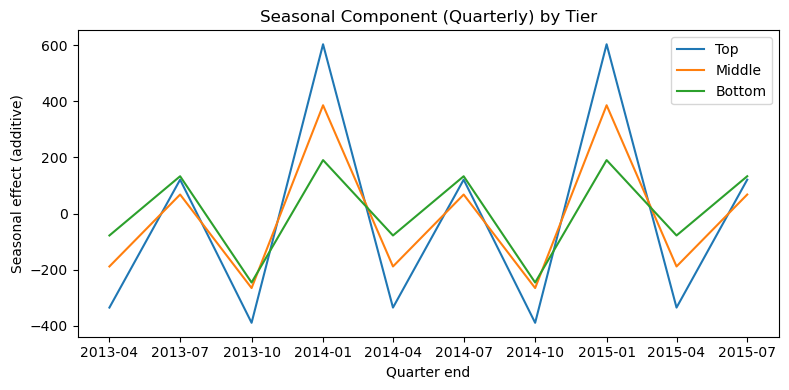

In [17]:
# Seasonality (Quarterly) — Percentages + Overlay Plot 
TIERS = ["Top", "Middle", "Bottom"]

def make_complete_quarter_series(tier_q_df, tier, freq_str='Q-DEC'):
    df_t = tier_q_df[tier_q_df['Tier'] == tier].copy()
    if df_t.empty:
        return pd.Series(dtype=float)

    if not isinstance(df_t['Quarter'].dtype, PeriodDtype):
        df_t['Quarter'] = df_t['Quarter'].astype('period[Q]')

    qmin, qmax = df_t['Quarter'].min(), df_t['Quarter'].max()
    full_pidx = pd.period_range(qmin, qmax, freq=freq_str)

    s_per = (df_t.set_index('Quarter').sort_index()['Sales']).reindex(full_pidx)
    s = s_per.to_timestamp(how='end')  # quarter-end timestamps
    s = (s.replace([np.inf, -np.inf], np.nan)
           .interpolate(method='time', limit_direction='both')
           .ffill().bfill().astype(float))
    s.name = tier
    return s

def manual_quarterly_decompose_additive(ts):
    # Trend: MA(4) then centered with MA(2) for even-period fix
    ma4   = ts.rolling(window=4, center=True, min_periods=2).mean()
    trend = ma4.rolling(window=2, center=True, min_periods=1).mean()

    detr  = ts - trend
    qnum  = detr.index.quarter
    seas_means = pd.Series({k: detr[qnum == k].mean() for k in [1,2,3,4]})
    seas_means = seas_means - seas_means.mean()  # center to 0

    seasonal = pd.Series(index=ts.index, dtype=float)
    for k in [1,2,3,4]:
        seasonal[qnum == k] = seas_means[k]

    resid = ts - trend - seasonal
    return {k: v.ffill().bfill() for k, v in {
        'observed': ts, 'trend': trend, 'seasonal': seasonal, 'resid': resid
    }.items()}

def metrics_for_tier(tier_name):
    ts = make_complete_quarter_series(tier_q, tier_name)
    if len(ts) == 0:
        return None
    comp = manual_quarterly_decompose_additive(ts)

    observed = comp["observed"].astype(float)
    seasonal = comp["seasonal"].astype(float)
    resid    = comp["resid"].astype(float)

    mean_sales = float(observed.mean())

    # Seasonality % = seasonal semi-amplitude / mean sales * 100
    seasonal_range = float(seasonal.max() - seasonal.min())
    seasonal_pct = (seasonal_range / 2.0 / mean_sales) * 100.0

    # Residual % metrics
    resid_mar_pct   = (float(resid.abs().mean()) / mean_sales) * 100.0
    resid_range_pct = (float(resid.max() - resid.min()) / mean_sales) * 100.0
    resid_peak_pct  = (max(abs(resid.min()), abs(resid.max())) / mean_sales) * 100.0

    return {
        "Tier": tier_name,
        "seasonal_pct": seasonal_pct,
        "resid_mar_pct": resid_mar_pct,
        "resid_range_pct": resid_range_pct,
        "resid_peak_pct": resid_peak_pct,
    }

# Compute percentages 
rows = []
for T in TIERS:
    if T in tier_q["Tier"].unique():
        m = metrics_for_tier(T)
        if m: rows.append(m)

dfm = pd.DataFrame(rows)

# Overlay plot: Seasonal Component (Quarterly) by Tier 
plt.figure(figsize=(8,4))
for tier in TIERS:
    if tier in tier_q['Tier'].unique():
        ts = make_complete_quarter_series(tier_q, tier)
        comp = manual_quarterly_decompose_additive(ts)
        plt.plot(comp['seasonal'], label=tier)

plt.title("Seasonal Component (Quarterly) by Tier")
plt.xlabel("Quarter end")
plt.ylabel("Seasonal effect (additive)")
plt.legend()
plt.tight_layout()
plt.show()

 **Figure 1.2 : Seasonal Component (Quarterly) by Tier**

In [8]:
# --- Minimal console summary ---
print("=== Seasonality & Residuals — Percentages ===")
for T in TIERS:
    r = dfm[dfm["Tier"] == T]
    if not r.empty:
        r = r.iloc[0]
        print(
            f"{T}: "
            f"Seasonality {r['seasonal_pct']:.2f}% | "
            f"Residual mean-abs {r['resid_mar_pct']:.2f}% | "
            f"Range {r['resid_range_pct']:.2f}% | "
            f"Peak {r['resid_peak_pct']:.2f}%"
        )

=== Seasonality & Residuals — Percentages ===
Top: Seasonality 4.77% | Residual mean-abs 1.12% | Range 3.71% | Peak 2.81%
Middle: Seasonality 4.96% | Residual mean-abs 1.33% | Range 3.31% | Peak 2.64%
Bottom: Seasonality 4.92% | Residual mean-abs 2.44% | Range 8.70% | Peak 5.22%


**Table 1.2 : Seasonality & Residual Percentages**

### **Key Insights**  
Figure 1.2 reveals a consistent annual seasonality across all tiers, with sales peaking in Q1 and declining mid-year. However, the predictability of each tier varies significantly.

The **Top tier** shows the most pronounced and stable seasonal cycles. While its absolute seasonal amplitude is the largest, its relative seasonality (4.77%) is moderate, and it has the lowest residual error (1.12%). This indicates highly structured and predictable sales behavior.

The **Middle tier** displays a similar pattern with moderate seasonality (4.96%) and residual error (1.33%), showing reasonable stability.

In contrast, the **Bottom tier**, despite a comparable seasonality (4.92%), exhibits the highest residual error (2.44%) and range. This points to greater internal irregularity and less predictable sales after accounting for trend and seasonality.

In summary, while the seasonal pattern is consistent network-wide, the Top tier demonstrates superior predictability with stable cycles and minimal unexplained noise.

In [9]:
# Use the tier_q table from earlier (quarterly average sales per store)
# Ensure sorted
tier_q = tier_q.sort_values(['Tier','Quarter']).copy()

# Train/test split: train up to 2014Q4, test = 2015Q1–2015Q2
train_end = pd.Period('2014Q4')
test_start = pd.Period('2015Q1')

results = []

for tier in ['Top','Middle','Bottom']:
    s = tier_q[tier_q['Tier']==tier].set_index('Quarter')['Sales']
    
    train = s[s.index <= train_end]
    test  = s[s.index >= test_start]
    
    # Simple seasonal naive forecast (lag 4 quarters back) 
    fc = test.copy()
    for q in test.index:
        prev = q - 4  # same quarter last year
        fc.loc[q] = train.get(prev, np.nan)
    
    # Align indices
    fc = fc.dropna()
    test = test.loc[fc.index]
    
    # Metrics 
    mae  = mean_absolute_error(test, fc)
    rmse = np.sqrt(mean_squared_error(test, fc))
    mape = np.mean(np.abs((test - fc) / test)) * 100
    
    results.append({
        "Tier": tier,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE_%": mape
    })

metrics_df = pd.DataFrame(results)
print(metrics_df.to_string(index=False))

  Tier        MAE       RMSE   MAPE_%
   Top 276.074834 279.187932 2.629754
Middle 208.256900 212.829316 3.110759
Bottom 205.246823 208.886035 4.414502


**Table 1.3:** Forecasting Accuracy Comparison by Tier — *Seasonal Naïve Lag-4 Model*

### **Key Insights**  
The Seasonal Naïve Lag-4 model reveals clear performance differences across tiers (Table 1.3). The **Top tier** achieved the **lowest MAPE (2.63%)**, confirming the highest forecast accuracy, as its strong, consistent seasonal patterns yield reliable forecasts. The **Middle tier** showed moderate accuracy with a MAPE of 3.11%, while the **Bottom tier** had the **highest MAPE (4.41%)**, reflecting its more volatile sales trends.

In absolute terms, the **Top tier's MAE (276.07)** and **RMSE (279.19)** are larger due to higher sales volumes, but its errors are proportionally the smallest. The Middle and Bottom tiers have smaller absolute errors but larger percentage errors, indicating less stability relative to their sales levels.

Overall, the **Top tier** demonstrates the most predictable sales behavior, supported by lower relative errors and clearer seasonal patterns, making it the most dependable group for operational planning.

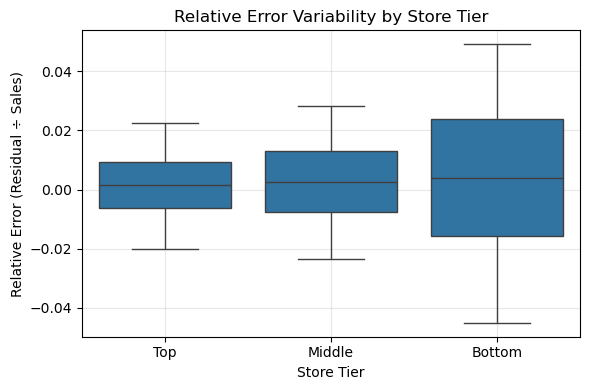

In [10]:
# Build monthly average sales series per tier 
def make_monthly_series(df, tier_name):
    s = (df[df['Tier'] == tier_name]
         .set_index('Date')
         .groupby(pd.Grouper(freq='M'))['Sales']
         .mean())
    # ensure regular monthly index & fill gaps
    s = s.asfreq('M')
    s = s.interpolate(method='time').ffill().bfill()
    return s

# Build monthly series for each tier
top_s    = make_monthly_series(df, "Top")
middle_s = make_monthly_series(df, "Middle")
bottom_s = make_monthly_series(df, "Bottom")

# Seasonal decomposition (period=12 for monthly seasonality) 
decompositions = {
    "Top":    seasonal_decompose(top_s,    model="additive", period=12),
    "Middle": seasonal_decompose(middle_s, model="additive", period=12),
    "Bottom": seasonal_decompose(bottom_s, model="additive", period=12),
}

# Collect relative errors (residual ÷ observed) 
relerr_rows = []
for tier, decomp in decompositions.items():
    observed = pd.Series(decomp.observed, index=decomp.observed.index)
    resid    = pd.Series(decomp.resid, index=decomp.resid.index).dropna()
    relerr   = resid / observed.loc[resid.index]
    relerr_rows.extend([(tier, v) for v in relerr.values])

relerr_df = pd.DataFrame(relerr_rows, columns=["Tier", "RelativeError"])

# Plot relative error variability 
plt.figure(figsize=(6,4))
sns.boxplot(x="Tier", y="RelativeError", data=relerr_df, order=["Top","Middle","Bottom"])
plt.title("Relative Error Variability by Store Tier")
plt.ylabel("Relative Error (Residual ÷ Sales)")
plt.xlabel("Store Tier")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

 **Figure 1.3 : Relative Error Variability by Store Tier**

### **Key Insights**  
**Figure 1.3** visualises the variability of relative errors across store tiers using a boxplot. The **Top tier** shows the **narrowest interquartile range (IQR)** and the smallest overall spread, indicating that its residuals remain close to zero and that its forecasts are the most stable. The **Middle tier** shows a slightly wider distribution, with moderate variation in residuals. Its errors are mostly centred around zero, suggesting decent predictability but slightly higher inconsistency compared to the Top tier. The **Bottom tier** displays the **widest range of relative errors**, extending from roughly **–0.045 to +0.045**, showing higher dispersion and greater susceptibility to random fluctuations or local influences.  

The symmetry of the **Top-tier boxplot** and its minimal outliers indicate that its model errors are balanced and consistently small, reflecting **strong trend and seasonal representation** in the decomposition. In contrast, the **Bottom tier’s larger and uneven spread** suggests that external or store-specific factors (e.g., inconsistent promotions, irregular customer flow) affect its predictability.  

Overall, the **Top-tier stores** once again demonstrate **the highest forecasting stability**, as indicated by their **low and symmetric relative errors**, while the **Bottom tier** remains the least stable and most error-prone group.

## **Question 2:** How do promotions, public holidays, and different days of the week influence sales patterns, and which factors have the strongest impact?

**Name:** Elaine Tjandra <br>

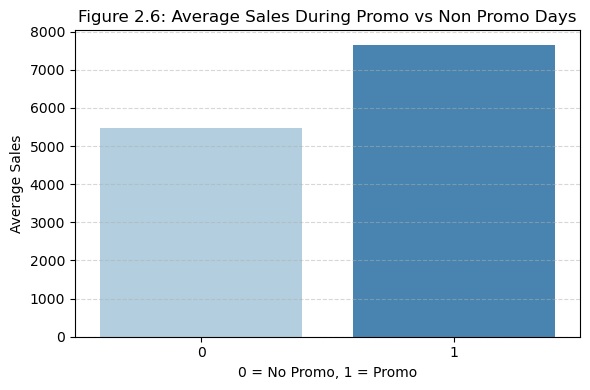

In [11]:
# Seperate dataset by promo and non promo
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x="Promo", y="Sales", estimator=np.median, errorbar=None, palette="Blues")

# Label and decorate bar graph
plt.title("Figure 2.6: Average Sales During Promo vs Non Promo Days")
plt.xlabel("0 = No Promo, 1 = Promo")
plt.ylabel("Average Sales")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observations**  
The graph above shows a bar graph of the average sales during promo and non promo days. The O axis label refers to the days without any promo and the 1 axis label refers to the days with promo. It can observed the **average sales made on promo days are significantly higher than sales without promo days**, being almost twice as much higher. The average sales on no promo days have an average of approximately 5500 sales while the average sales on promo days have an average of approximately 7800 sales.

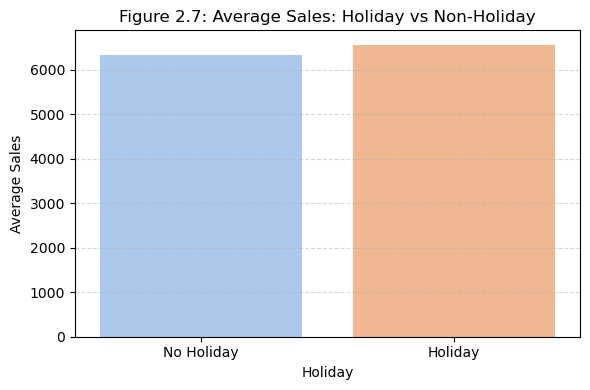

In [12]:
# Creates a new column "Holiday" that is 1 when "StateHoliday" or "SchoolHoliday" is true
df['Holiday'] = ((df['StateHoliday'] == 1) | (df['SchoolHoliday'] == 1)).astype(int)

# Calculate average sales
avg_sales_combined = df.groupby('Holiday')['Sales'].median().reset_index()

# Plot bar graph
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_sales_combined, x='Holiday', y='Sales', palette='pastel')
plt.title('Figure 2.7: Average Sales: Holiday vs Non-Holiday')
plt.xticks([0, 1], ['No Holiday', 'Holiday'])
plt.ylabel('Average Sales')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observation**  
The graph above shows a bar graph of the average sales during days with and without holidays. In this case, a holiday is either a state or school holiday. The **average sales is slighty higher during holidays.** The average sales on no holidays is approximately 6300 sales, while the average sales on holidays is approximately 6700 sales.

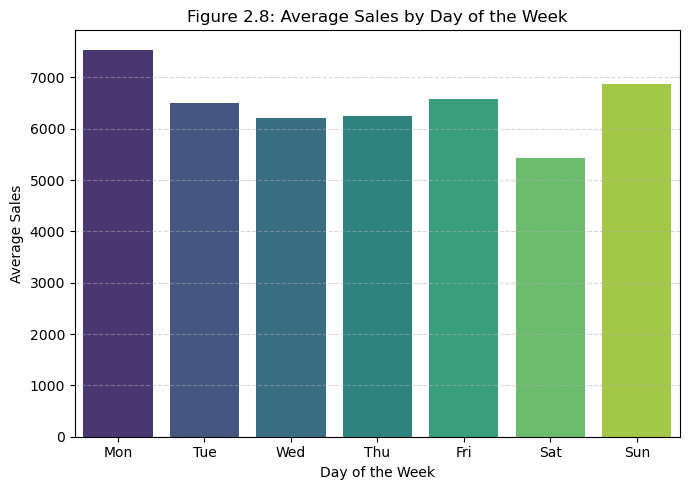

In [13]:
# Calculate average sales for each day of the week
avg_sales_by_day = df.groupby('DayOfWeek')['Sales'].median().reset_index()

# Make names for each day of the week
day_map = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu',5: 'Fri', 6: 'Sat', 7: 'Sun'}
avg_sales_by_day['DayName'] = avg_sales_by_day['DayOfWeek'].map(day_map)

# Sort days in week order
avg_sales_by_day = avg_sales_by_day.sort_values('DayOfWeek')

# Plots the bar graph
plt.figure(figsize=(7, 5))
sns.barplot(data=avg_sales_by_day, x='DayName', y='Sales', palette='viridis')

plt.title('Figure 2.8: Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observations**  

The graph above shows the average sales made throughout the different days of the week. It can be observed that **the highest average sales was made on Monday**, having an average sales of approximately 7500 sales. The **lowest average sales was observed to be on Saturday**, having an average sale of 5400 sales. The average sales on Wednesday and Thursday appear to be quite similar, suggesting consistent customer purchasing behavior in the middle of the week. Overall, the variation in sales across the week may reflect differences in customer availability, shopping habits, or promotional activities tied to specific days.

### **Overall Conclusion and Implications**
#### **Conclusion**
**Promotions and holidays:**  
Both have a positive impact toward demand, driving the average sales, with promotions being more effective

**Day of week patterns:**
- Highest average sales found on Monday
- Lowest average sales found on Saturday
- Stable average sales in the middle of the week

#### **Implications**
**Marketing team:**
- It is clear that customers favor promotions, this can lead to low sales on non-promo days.
- The team can consider creating a loyalty program do boost sales on non-promo days.
- The team should also find strategies to boost sales on certain days

**Finance team:**
- Ensure promotional price still produce profit.
- Identify which marketing strategies generate the most profit.
- Allocate more budget on days with lower sales.

**Supply chain:**  
It must be ensured that supply needs and demands are met especially during promotion period or busier days.

**Human resource:**  
Allocate more staffs on busier days to manage higher customer traffic.

## **3. Predictive Modelling**

## **Question 3:** How accurately can we forecast sales for the Rossmann stores, and which factors contribute most?

**Name:** Jingyuan Yao <br>

### **3.1 Feature Engineering**

In [14]:
# Time-based features
df_copy['Quarter'] = df_copy['Date'].dt.quarter

# One-Hot Encoding
df_copy = pd.get_dummies(
    df_copy,
    columns=['StateHoliday', 'Year', 'Month', 'DayOfWeek', 'Quarter'],
    drop_first=True
)

# Lag & Rolling
df_copy = df_copy.sort_values(['Store', 'Date'])
df_copy['Sales_Lag_7'] = df_copy.groupby('Store')['Sales'].shift(7) # sales before 7 days

df_copy['Sales_MA_7'] = (
    df_copy.groupby('Store')['Sales']
    .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()) # Rolling for 1 week (Average for the past 7 days)
)

# Handling missing value
df_copy['Sales_Lag_7'] = df_copy['Sales_Lag_7'].fillna(0)
df_copy['Sales_MA_7'] = df_copy['Sales_MA_7'].fillna(df_copy['Sales'].mean()) # imputation

**One-Hot Encoding**  
One-hot encoding (Géron, 2019) was applied to categorical variables, with the first category dropped to avoid the dummy variable trap (e.g., DayOfWeek=1, Month=1, Year=2013). Thus, each coefficient represents the change in sales relative to the baseline category.

**Lag & Rolling**  
Lag and rolling features were constructed to capture temporal dependencies in sales data (Box et al., 2008).  
- `Sales_Lag_7` represents the sales value from one week prior, helping the model recognize weekly seasonality.  
- `Sales_MA_7` is a 7-day moving average that smooths short-term fluctuations and highlights recent trends.

Together, these features provide the model with crucial short-term memory and trend information, significantly improving its ability to forecast future sales.

In [15]:
# Selecting features and target
feature_cols = (
    ['Promo', 'SchoolHoliday', 'Sales_Lag_7', 'Sales_MA_7'] +
    [col for col in df_copy.columns if col.startswith('StateHoliday_')] +
    [col for col in df_copy.columns if col.startswith('Year_')] +
    [col for col in df_copy.columns if col.startswith('Month_')] +
    [col for col in df_copy.columns if col.startswith('DayOfWeek_')] +
    [col for col in df_copy.columns if col.startswith('Quarter_')]    
)

X = df_copy[feature_cols]
y = df_copy['Sales']

# Normalize features (only for X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Wrap the scaled array into a DataFrame, preserving column names and index
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Split the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)

### **3.2 Multivariate Linear Regression**
The Multivariate Linear Regression (MLR) model (Draper & Smith, 1998) assumes that sales can be expressed as a linear combination of multiple predictors such as Promo, DayOfWeek, and recent sales trends (Sales_MA_7). Each feature contributes additively to the predicted sales based on its regression coefficient, indicating the strength and direction of influence.

MLR was chosen for its simplicity and interpretability, it provides clear insights into how each factor quantitatively affects sales, making it suitable as a baseline model for identifying key drivers of sales performance.

In [16]:
# Multiviate regression modeling
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction
y_pred_lr = model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred_lr)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred_lr)

# Result
print("Intercept:", model.intercept_)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Intercept: 6956.035396429127
MSE: 2602871.36
RMSE: 1613.34
R²: 0.7310


#### **Linear Regression - Model Evaluation**  
- R² = 0.731, the model explains about 73% of sales, which is quite explanatory.
- RMSE (1613.34): The mean square error and root mean square error are large, this model may need further optimization.

**Visualizing the Results**

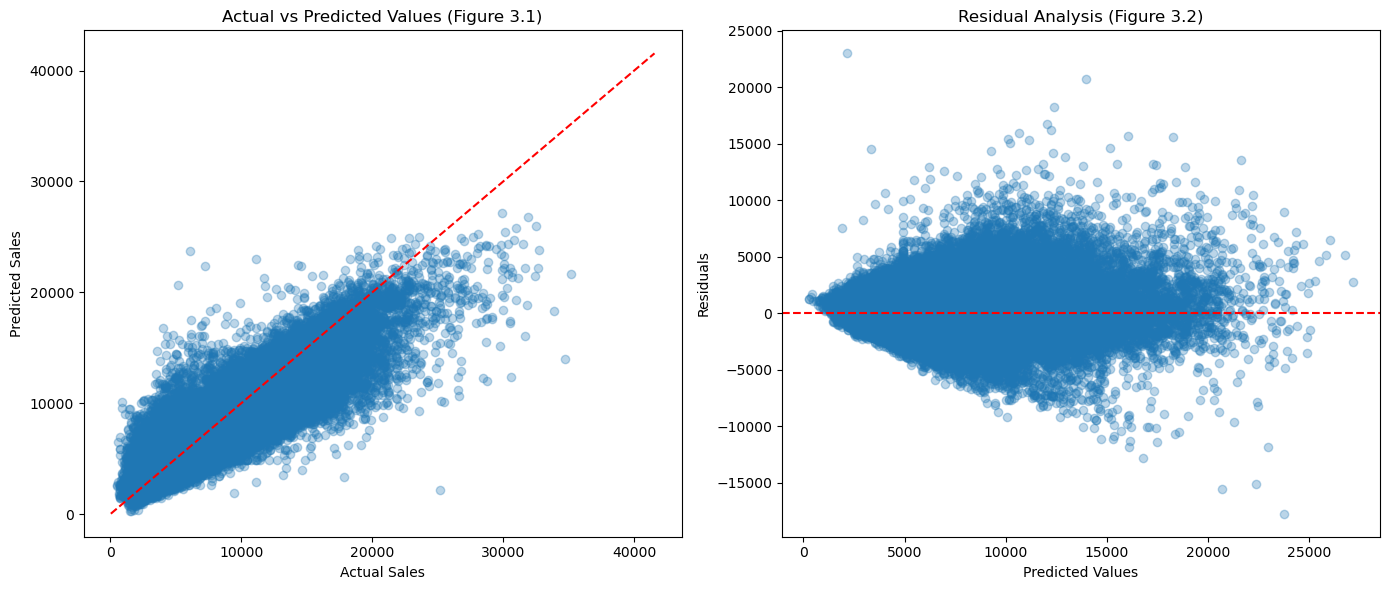

In [17]:
# Set up plot
plt.figure(figsize=(14, 6))

# Scatter plot of actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Values (Figure 3.1)')

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_lr
plt.scatter(y_pred_lr, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Figure 3.2)')

plt.tight_layout()
plt.show()

- In the actual vs predicted plot (Figure 3.1), most points are concentrated but show a visible spread around the diagonal line, especially when the sales is greater than 20,000. This indicates that while the model captures the general sales trend, there is still a noticeable prediction error, especially for higher sales values where the model tends to underestimate.

- In the residual plot (Figure 3.2), residuals are generally centred around zero, but there is a visible funnel-shaped pattern, suggesting potential heteroscedasticity. At lower predicted values, residuals are mostly positive; At higher predicted values, residuals tend to be negative. This pattern implies that the model’s prediction errors increase with higher predicted values, indicating this model may has potential issues such as: the relationship between predictors and target is non-linearity, need further transformation/regularisation to stabilise variance.

#### **Model Accuracy and Forecasting Reliability**
The regression model can explain approximately 75% of the variance in store sales, suggests that the model captures the main sales drivers, but there is still a considerable portion of unexplained variation. However, the residual analysis shows that prediction errors increase significantly for higher sales values. This means that while the model is suitable for regular operations such as inventory planning or staff scheduling, it may underestimate demand during high-volume periods such as holiday seasons or major promotions. From a business perspective, relying solely on this model in peak sales periods could risk stockouts or insufficient staffing.  

From a business standpoint, we would need more advanced models, possibly incorporating external factors such as competitor pricing, local events, or weather, to better forecast peak demand.

#### **Linear Regression - Feature importance**

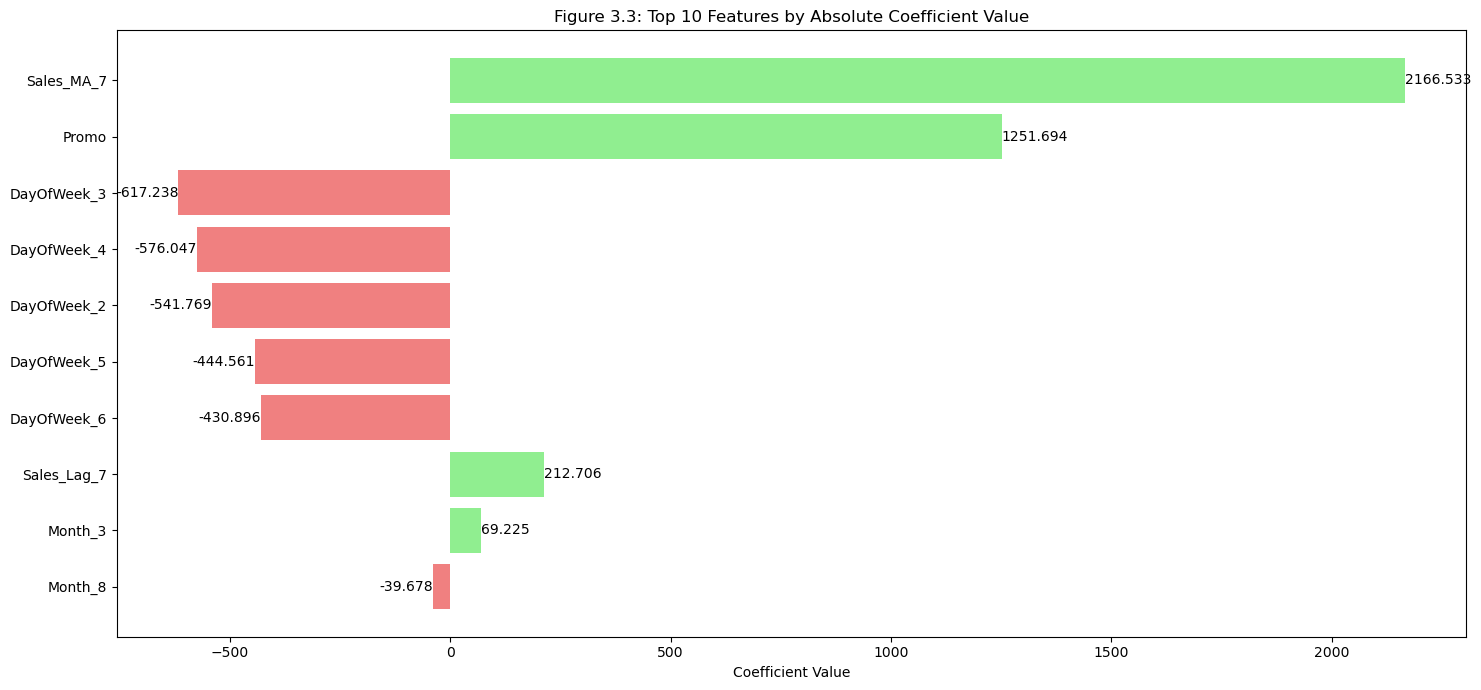

In [18]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

# Take the top 10 features with the largest absolute values
top_features = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10)

# Plotting
plt.figure(figsize=(15,7))
bars = plt.barh(
    top_features['Feature'],
    top_features['Coefficient'],
    color=['lightgreen' if x > 0 else 'lightcoral' for x in top_features['Coefficient']]
)

plt.xlabel('Coefficient Value')
plt.title('Figure 3.3: Top 10 Features by Absolute Coefficient Value')
plt.gca().invert_yaxis()  # y-axis in reverse order

for bar, value in zip(bars, top_features['Coefficient']):
    plt.text(
        bar.get_width(),                        # X coordinate: end of bar
        bar.get_y() + bar.get_height()/2,       # Y coordinate: center of bar
        f'{value:.3f}',                        # 3 decimal places
        va='center',
        ha='left' if value >= 0 else 'right'    # Positive numbers are written to the right, negative numbers to the left
    )

plt.tight_layout()
plt.show()

**Observation**  
The figure shows the direction and magnitude of each feature's influence on sales in the multiple regression model. The horizontal axis represents the regression of coefficient values, while the vertical axis lists the feature names. 

Among the features, `Sales_MA_7` has the largest positive effect (coefficient = 2166.5), indicating that for every one-unit increase in the 7-day moving average of sales, the current sales volume increases by approximately 1191 units, reflecting strong temporal dependence in sales. `Promo` also has a substantial positive impact (coefficient = 1251.7), with sales increasing by around 1252 units on promotional days compared to non-promotional days, highlighting the effectiveness of promotions. Seasonal effects are observed for Month_3, with sales in March increasing by 69 units relative to January when other factors are held constantly. Regarding DayOfWeek, Monday is used as the benchmark, and all other days show negative coefficients, with Wednesday having a particularly low effect (coefficient = -617), suggesting that average sales are highest on Mondays.
  
This result indicates that `Sales_MA_7`, `Promo`, and `DayOfWeek` are the most important features for prediction. 

### **3.3 Random Forest Regressor**
The Random Forest (RF) algorithm (Breiman, 2001) is an ensemble learning method that constructs multiple decision trees on randomly sampled subsets of the training data and input features. The final prediction is obtained by averaging the outputs of these trees, which reduces variance and improves generalization performance.

Unlike linear models, RF can naturally capture complex, non-linear relationships and feature interactions — for instance, how the impact of Promo on sales may vary depending on Holiday or Month. This makes it particularly effective for modeling heterogeneous patterns in large retail datasets such as Rossmann’s.

In [19]:
# Random forest regressor modelling
rf = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=20,    # Maximum tree depth (adjustable)
    random_state=42,
    n_jobs=-1          # Accelerate using all CPU cores
)

# Fitting model
rf.fit(X_train, y_train)

# Predicting
y_pred_rf = rf.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R2: {r2_rf:.4f}")

Random Forest MSE: 1494614.52
Random Forest RMSE: 1222.54
Random Forest R2: 0.8456


**Random Forest Model Evaluation**  
- R² = 0.8456, the model explains about 85% of sales, which can be considered as a good predict model.
- RMSE = 1222.54 indicates that the model's prediction error is approximately $929.

#### **Visualizing the Results**

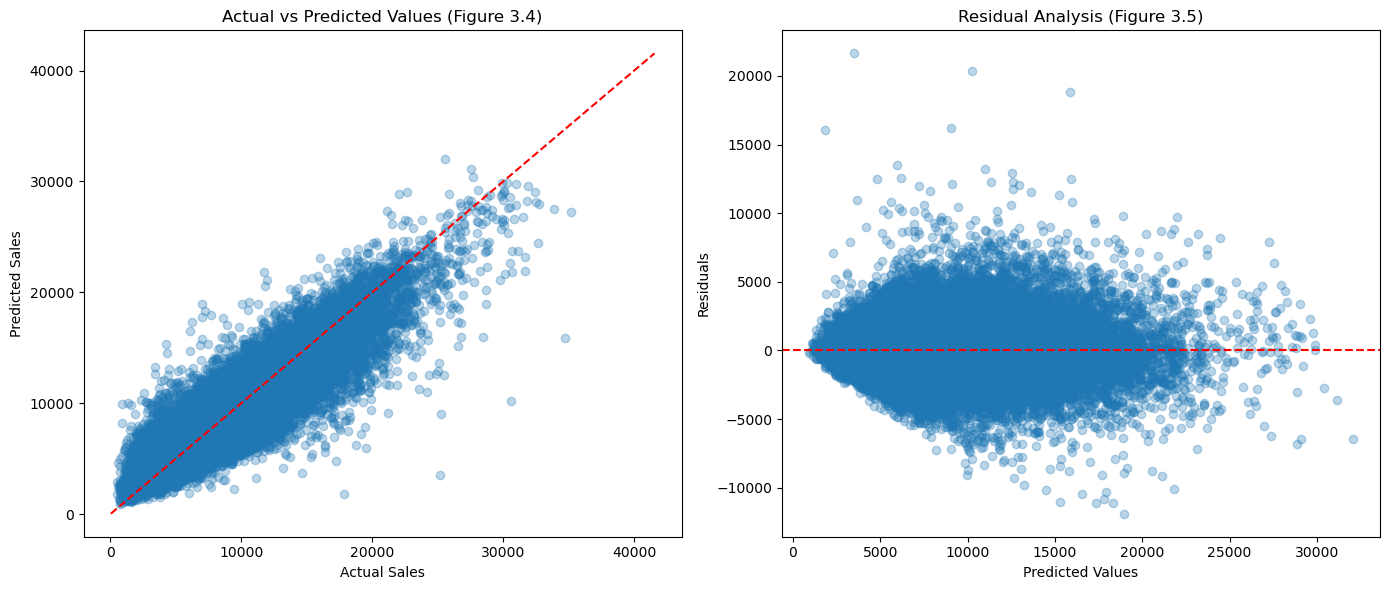

In [20]:
# Set up plot
plt.figure(figsize=(14, 6))

# Scatter plot of actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Values (Figure 3.4)')

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Figure 3.5)')

plt.tight_layout()
plt.show()

#### **Model Evaluation - Comparing RF with LR**
The Actual vs. Predicted plot (Figure 3.5) shows that the Random Forest model captures the overall sales trend, but its predictions are somewhat under-predicted and exhibit significant scatter in the high-sales range. The residual analysis (Figure 3.6) generally exhibits a spindle-shaped pattern, showing that most residuals are concentrated around 5000 points above or below zero, slightly lower than the linear regression model. While there are also some points with significant errors, the overall performance is better than that of the linear regression model.

Both models share a common characteristic: they are relatively accurate in the low- to medium-sales range, but their predictions are insufficient at high sales levels. This is likely due to the smaller sample size in the high-sales range.

#### **Random Forest - Feature Importance**

      Feature  Importance
   Sales_MA_7    0.636250
        Promo    0.161893
  Sales_Lag_7    0.048953
  DayOfWeek_3    0.025980
  DayOfWeek_2    0.025810
  DayOfWeek_5    0.023943
  DayOfWeek_4    0.015625
     Month_12    0.008660
SchoolHoliday    0.007897
    Year_2014    0.007068


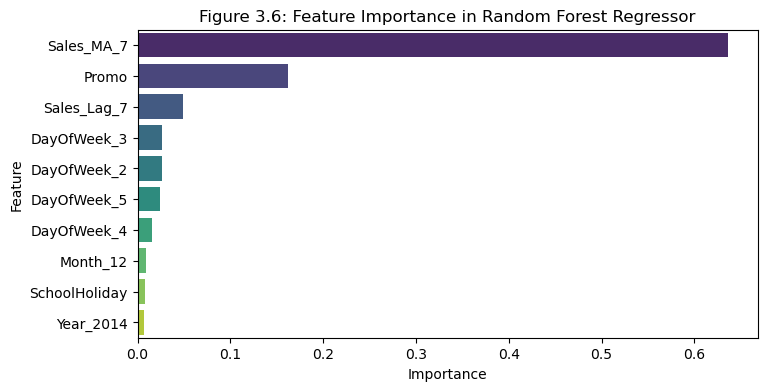

In [21]:
feature_importances_rf = pd.Series(rf.feature_importances_, index=feature_cols)
top10_importances_rf = feature_importances_rf.sort_values(ascending=False).head(10)

top10_df = top10_importances_rf.reset_index()
top10_df.columns = ['Feature', 'Importance']

print(top10_df.to_string(index=False))

# Plot the feature importances
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=top10_df, palette='viridis')
plt.title('Figure 3.6: Feature Importance in Random Forest Regressor')
plt.show()

In the random forest model, we use feature importance to measure the contribution of each variable to sales prediction. The results show that `Sales_MA_7` is the most important, accounting for approximately 63.6%, far exceeding other variables. This is followed by `Promo` (16.2%) and `Sales_Lag_7` (4.9%), indicating that the number of customers, historical sales trends, and promotions are the primary drivers. In contrast, features such as month and holidays have lower importance (less than 1%).

### **3.4 Comparison, Explaination & Implications**
#### **Key Sales Drivers**  
Among all variables except customers amount, promotional activities have the strongest positive impact. This is consistent with Rossmann’s business model, where discounts on everyday essentials and personal care products are a major driver of foot traffic. This finding supports managerial intuition and suggests that managers can further evaluate the effectiveness of different campaigns to maximize sales uplift. 
  
The **linear regression model** highlighted `March (Month_3)` as having a stronger positive coefficient, while `December (Month_12)` appeared less important. In contrast, the **random forest model** assigned high importance to `December`, and our earlier EDA also showed that mean and median sales tended to rise toward the end of the year.  
This apparent contradiction can be explained by *multicollinearity*: December frequently coincides with heavy promotional activities, causing the linear model to attribute most of the uplift to promotions rather than to the month itself. The Random Forest, however, captures both seasonal and promotional signals, reinforcing December’s importance. Together, these results suggest that the year-end spike is largely promotion-driven, making December a critical period for campaign planning and inventory allocation. 
  
#### **Holiday and Weekday Effects**  
Even when stores remain open, state holidays still show negative coefficients. This may be because customers tend to stock up in advance before the holidays and then shift their spending to recreational or family activities during the holidays themselves. As a result, holiday sales volumes drop despite stores being open. The strong negative effect of Sunday also aligns with the European retail context, where most stores are either closed or operate under restricted hours. This explains why Sunday sales are substantially lower and suggests that operational resources, such as staffing and inventory, should be minimized on that day.


## **Question 4:** When and where does the model make the largest prediction errors? (error aalysis)

**Name:** Yin Haotian <br>

In [22]:
# Linear regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results_df = pd.DataFrame({
    "Store": df.loc[y_test.index, "Store"], 
    "Promo": df.loc[y_test.index, "Promo"],
    "Actual": y_test,
    "Predicted": y_pred
})

results_df["Error"] = results_df["Predicted"] - results_df["Actual"]
results_df["AbsError"] = results_df["Error"].abs()

holiday_cols = [c for c in X.columns if c.startswith("StateHoliday_") and c != "StateHoliday_0"]
results_df["IsHoliday"] = (X.loc[y_test.index, holiday_cols].sum(axis=1) > 0).astype(int)

print(f"On average, its predictions are off by: ${results_df['AbsError'].mean():.2f}\n")

On average, its predictions are off by: $1182.87



### PART 1: Checking the Model's Mistakes (Error Analysis)

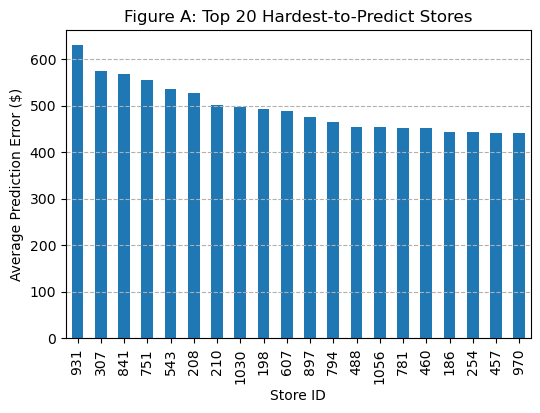

In [23]:
store_error = results_df.groupby('Store')['Error'].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
store_error.head(20).plot(kind='bar')
plt.title('Figure A: Top 20 Hardest-to-Predict Stores')
plt.xlabel('Store ID')
plt.ylabel('Average Prediction Error ($)')
plt.grid(axis='y', linestyle='--')
plt.show()

**Key Findings**  
Figure A shows that some stores—particularly Store 931, Store 307, and Store 841—exhibit substantially higher average prediction errors than others. Most stores have lower and relatively stable error rates, but a few outliers demonstrate extreme deviations. This variation suggests significant heterogeneity in store-level sales dynamics, which the model fails to capture effectively.

**Interpretation**  
The results indicate that the model performs inconsistently across stores, with some locations being systematically harder to predict. Possible explanations include irregular promotional schedules, inconsistent customer behavior, missing or noisy local data, or unobserved regional effects (e.g., competition, demographic differences). These findings imply that the current model may not generalize well to all stores. Future improvements could involve incorporating store-level categorical features (e.g., location type, average customer flow) or developing segmented models that account for distinct sales behaviors among different store clusters.

### PART 2: When Does the Model Make Bigger Mistakes?


Average prediction error on Promo vs. Non-Promo days:
Promo
0    1141.788216
1    1233.687407
Name: AbsError, dtype: float64

Average prediction error on Holiday vs. Normal days:
IsHoliday
0    1180.591445
1    3077.743826
Name: AbsError, dtype: float64


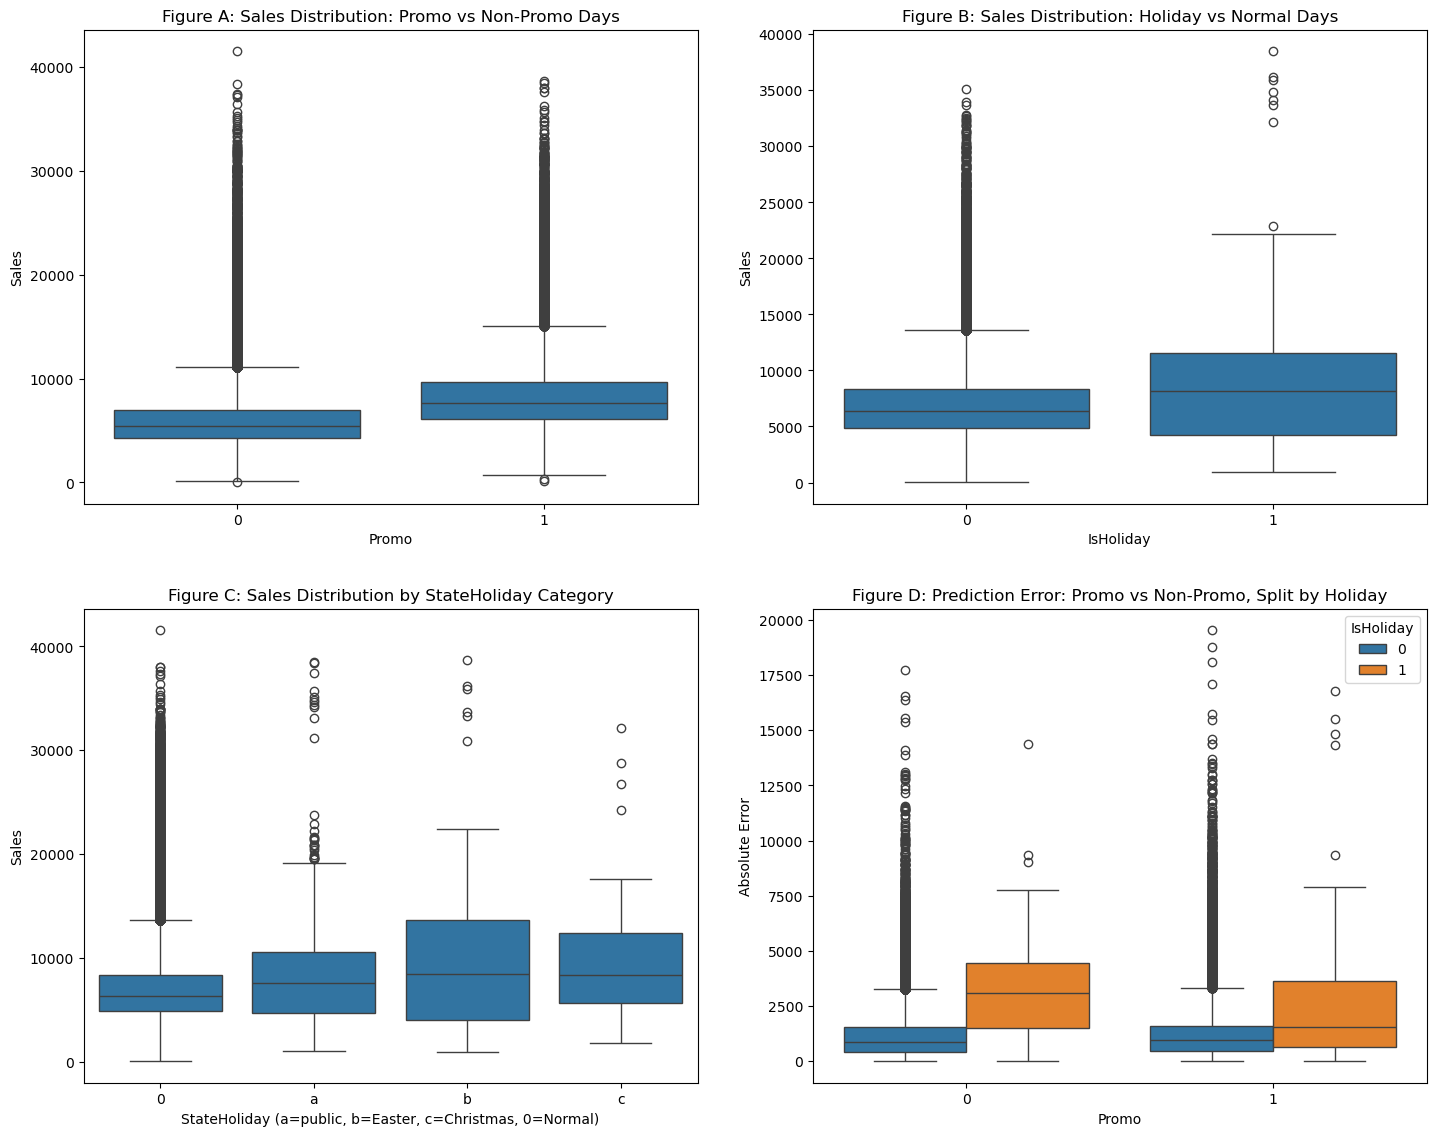

In [24]:
# Compare error on Promo vs Non-Promo days
promo_error = results_df.groupby('Promo')['AbsError'].mean()
print("\nAverage prediction error on Promo vs. Non-Promo days:")
print(promo_error)

# Compare error on Holiday vs Normal days
holiday_error = results_df.groupby('IsHoliday')['AbsError'].mean()
print("\nAverage prediction error on Holiday vs. Normal days:")
print(holiday_error)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sales distribution: Promo vs Non-Promo
sns.boxplot(x="Promo", y="Sales", data=df, ax=axes[0, 0])
axes[0, 0].set_title("Figure A: Sales Distribution: Promo vs Non-Promo Days")
axes[0, 0].set_xlabel("Promo")
axes[0, 0].set_ylabel("Sales")

# 2. Sales distribution: Holiday vs Normal days
holiday_df = results_df.merge(df[['Date','Sales']], left_index=True, right_index=True)
sns.boxplot(x="IsHoliday", y="Sales", data=holiday_df, ax=axes[0, 1])
axes[0, 1].set_title("Figure B: Sales Distribution: Holiday vs Normal Days")
axes[0, 1].set_xlabel("IsHoliday")
axes[0, 1].set_ylabel("Sales")

# 3. Break down sales by different StateHoliday categories
sns.boxplot(x="StateHoliday", y="Sales", data=df, ax=axes[1, 0])
axes[1, 0].set_title("Figure C: Sales Distribution by StateHoliday Category")
axes[1, 0].set_xlabel("StateHoliday (a=public, b=Easter, c=Christmas, 0=Normal)")
axes[1, 0].set_ylabel("Sales")

# 4. Prediction error distribution: Promo & Holiday
sns.boxplot(x="Promo", y="AbsError", hue="IsHoliday", data=results_df, ax=axes[1, 1])
axes[1, 1].set_title("Figure D: Prediction Error: Promo vs Non-Promo, Split by Holiday")
axes[1, 1].set_xlabel("Promo")
axes[1, 1].set_ylabel("Absolute Error")
axes[1, 1].legend(title="IsHoliday")

plt.tight_layout(pad=3.0)
plt.show()

**Key Findings**  
The results in Figures B–E reveal several key patterns:
- Sales during promotion days show significantly higher variance than on non-promotion days (Figure B), suggesting that customer response
to promotions is highly inconsistent.
- During holidays, sales fluctuate much more widely than on normal days (Figure C), making it harder for the model to generalize.
- Different state holiday types have distinct effects on sales (Figure D); for instance, Christmas and Easter lead to stronger deviations compared to ordinary public holidays.
- When promotions and holidays coincide, prediction errors reach their highest levels (Figure E), showing the model struggles most under overlapping high-variance conditions.

**Interpretation**  
These findings indicate that the model’s prediction accuracy is highly sensitive to contextual factors such as promotions and
holidays. The large variance in sales during these periods implies nonlinear and event-driven customer behaviors that the baseline model cannot fully capture. To improve performance, future model iterations could incorporate richer temporal and event-based features (e.g.,
holiday proximity, promotion type, or duration) or use specialized sub-models trained for high-variance scenarios. This targeted
refinement would likely reduce the systematic prediction errors observed under these complex conditions.

## **4. Conclusions and Further Steps**

### **Summary of Findings**
Analysis across multiple levels of the Rossmann dataset revealed consistent patterns in sales behaviour and forecast performance. The top-performing stores achieved the highest average sales and demonstrated the most stable trends, with the lowest relative variation and forecasting errors. Their sales followed clear seasonal cycles that repeated annually, confirming strong predictability. In contrast, bottom-tier stores displayed irregular fluctuations and weaker seasonal structures, leading to greater volatility and higher forecast errors.  

Exploratory analysis further showed that promotional activities nearly doubled average sales compared to non-promo days, highlighting their dominant role as a sales driver. Sales were slightly higher during holidays and peaked early in the week, suggesting customer purchasing patterns tied to weekly routines and retail scheduling.  

Modeling results identified promotions as the strongest positive predictor, followed by time-related variables such as month and weekday. The December effect, largely driven by intensive promotions, indicated that end-of-year campaigns significantly shape sales performance. Negative coefficients for holidays and Sundays reflected reduced demand when stores operate under limited hours.  

Finally, error analysis revealed that prediction accuracy declined during complex periods involving overlapping promotions and holidays, where customer behaviour became less predictable. Despite these challenges, the overall model effectively captured the main drivers of Rossmann’s sales dynamics, providing a reliable foundation for data-driven decision-making.  

### **Business Insights**
The findings provide several actionable insights for Rossmann’s store operations and planning.  
First, the strong stability of top-performing stores suggests they can serve as benchmarks for overall forecasting and management practices. While lower-performing stores may require tailored regional strategies to address local variability.  

Promotional activities emerged as the most influential sales driver, nearly doubling average revenue. However, their high variance indicates that not all promotions are equally effective. Rossmann could therefore focus on optimizing promotion timing and intensity, using predictive models to identify periods of weaker baseline demand where discounts yield the highest incremental gains. During overlapping holiday and promotion periods—where forecast errors increase—closer monitoring and adaptive inventory adjustments may be needed to manage unpredictable spikes in demand.  

Finally, sales patterns across weekdays highlight opportunities for operational optimization. Staffing and inventory can be increased on high-demand days such as Mondays, and reduced on Sundays or holidays when customer traffic declines.  

By integrating these insights into store-level decision-making, Rossmann can enhance forecast accuracy, improve resource allocation, and support more data-driven, efficient retail operations.  


### **Further Steps**
Future work could focus on enhancing both the modeling accuracy and the practical integration of forecasts into Rossmann’s operations. 

From a technical perspective, future models could incorporate additional variables such as store location characteristics, competitor density, or promotion type, which are likely to influence customer flow and seasonal demand. Exploring more advanced forecasting technique such as Gradient Boosting or Long Short-Term Memory (LSTM) networks, may also improve predictive performance, especially during volatile periods like holidays or overlapping promotions.

From a business standpoint, Rossmann could translate these forecasts into proactive planning tools. For instance, integrating the predictive model into store management systems would allow managers to anticipate demand fluctuations, optimize staffing, and manage inventory more efficiently. Continuous feedback between prediction outcomes and operational results would further refine the model and ensure that data-driven insights directly inform strategic decision-making.

## **References**

- Box, G. E. P., Jenkins, G. M., & Reinsel, G. C. (2008). *Time series analysis : forecasting and control* (4th edition). Wiley, a John Wiley & Sons, Inc.

- Breiman, L. (2001). Random forests. *Machine Learning, 45*(1), 5–32. https://doi.org/10.1023/A:1010933404324

- Chai, T., & Draxler, R. R. (2014). Root mean square error (RMSE) or mean absolute error (MAE)? – Arguments against avoiding RMSE in the literature. *Geoscientific Model Development*, 7(3), 1247–1250. https://doi.org/10.5194/gmd-7-1247-2014

- Draper, N. R., & Smith, H. (1998). *Applied regression analysis* (3rd ed.). John Wiley & Sons.

- Géron, A., & ProQuest. (2019). *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow : concepts, tools, and techniques to build intelligent systems* (Second edition.). O’Reilly.

- Kaggle. (2015). *Rossmann Store Sales*. Retrieved from https://www.kaggle.com/competitions/rossmann-store-sales


## **Appendix**

### AI Acknowledgement
This project made limited use of **ChatGPT (OpenAI, 2025)** to assist in **debugging Python code and refining code structure** during data analysis.  
All core analysis, interpretation, and decision-making were carried out independently by the authors. ChatGPT’s contribution was restricted to **technical troubleshooting and code clarity** in line with the Monash SAS guidelines on the responsible use of AI tools.

### Group Project Assessment
**Studio:** Wednesday 4 pm  
**Group:** MY-G2-Sales  

| **Category** | **Keshav Thinakaran** | **Elaine Tjandra** | **Jingyuan Yao** | **Yin Haotian** |
|:--------------|:-----------------|:------------:|:------------:|:------------:|
| **Coordination** | 25 | 25 | 25 | 25 |
| **Research** | 30 | 25 | 25 | 20 |
| **Coding** | 25 | 25 | 25 | 25 |
| **Report Writing** | 25 | 25 | 30 | 20 |
| **Presentation Preparation** | 25 | 30 | 25 | 20 |
| **Attendance at Final Presentation** | 1 | 1 | 1 | 1 |